# 1. Comprensión de datos

In [ ]:
# Dependencias
# pip install pandas
# pip install pyarrow
# pip install numpy
# pip install matplotlib
# pip install seaborn
# pip install scikit-learn


In [138]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import silhouette_score
from sklearn.utils import shuffle
from sklearn.decomposition import PCA



## Preparar el data set inicial

In [ ]:
# Ruta de los .parquet
DATA_PATH = "datos_examen"

# Cargar tabla principal (application)
app = pd.read_parquet(os.path.join(DATA_PATH, "application_train.parquet"))

print("\nDataset application_train cargado correctamente.")
print("Dimensiones:", app.shape)

app.head()

## Descripción de los datos

In [ ]:
# Mostrar dimensiones del dataset
print("Dimensiones del dataset (filas, columnas):", app.shape)

# Mostrar nombres de columnas
print("\nLista de columnas:")
for col in app.columns:
    print("-", col)

# Tipos de datos por columna
print("\nTipos de datos:")
print(app.dtypes.value_counts())

print("\nPrimeras 15 columnas con su tipo:")
print(app.dtypes.head(15))

In [ ]:
# Información general del dataset
print("\nInformación general del dataset:")
app.info()


In [ ]:
# Columnas categóricas
categoricas = app.select_dtypes(include=['object']).columns
print("\nNúmero de columnas categóricas:", len(categoricas))
print("Columnas categóricas:", list(categoricas))

# Mostrar valor único de las primeras categóricas
for col in categoricas[:5]:
    print(f"\nValores únicos de la columna '{col}':")
    print(app[col].unique()[:10])  # primeros 10 para no saturar


In [87]:
# Columnas numéricas
numericas = app.select_dtypes(include=['int64', 'float64']).columns
print("\nNúmero de columnas numéricas:", len(numericas))

print("\Resumen estadística:")
display(app[numericas].describe().T.head(10))


,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.00000,189145.500000,278202.00000,367142.500000,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.00000,0.000000,0.00000,0.000000,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.00000,0.000000,0.00000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.00000,112500.000000,147150.00000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.00000,270000.000000,513531.00000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1615.50000,16524.000000,24903.00000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,40500.00000,238500.000000,450000.00000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,0.00029,0.010006,0.01885,0.028663,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-25229.00000,-19682.000000,-15750.00000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-17912.00000,-2760.000000,-1213.00000,-289.000000,3.652430e+05


## Análisis inicial

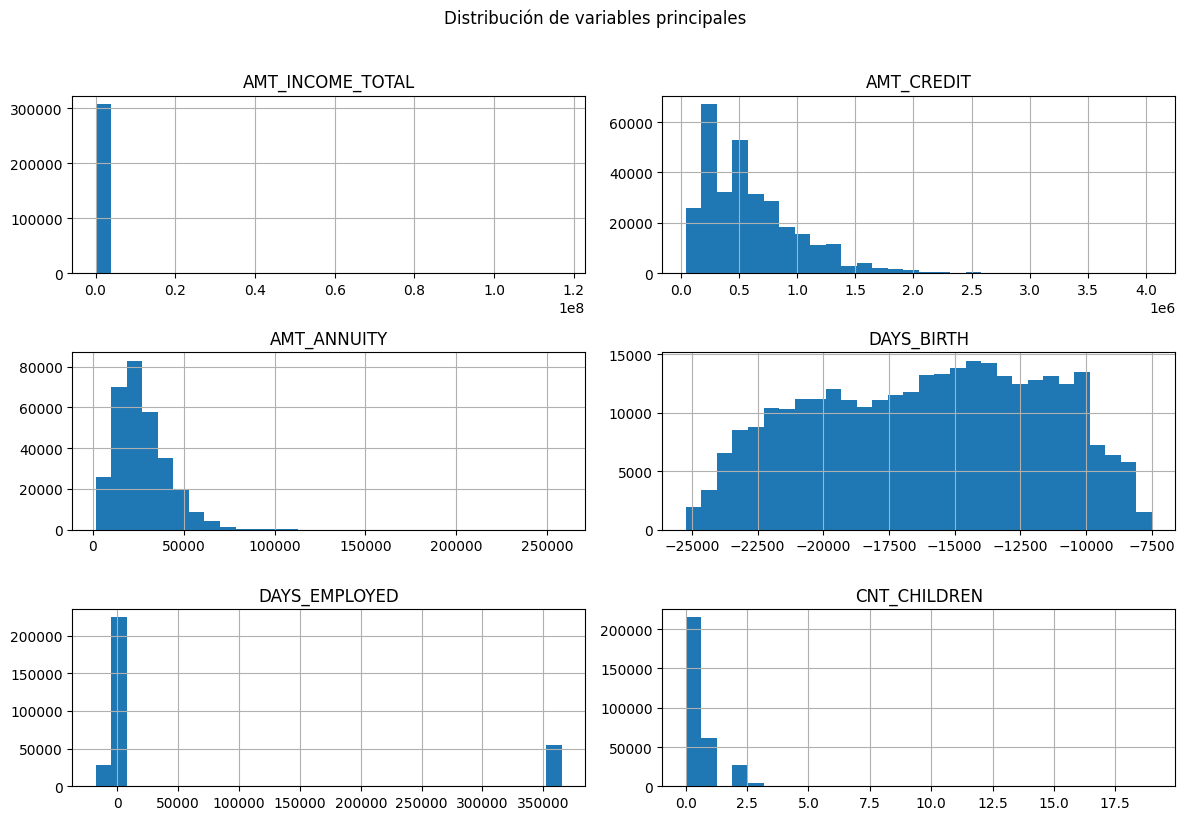

In [88]:
# Visualización de distribuciones de variables principales
vars_explorar = [
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "DAYS_BIRTH",
    "DAYS_EMPLOYED",
    "CNT_CHILDREN"
]

app[vars_explorar].hist(figsize=(12,8), bins=30)
plt.suptitle("Distribución de variables principales", y=1.02)
plt.tight_layout()
plt.show()

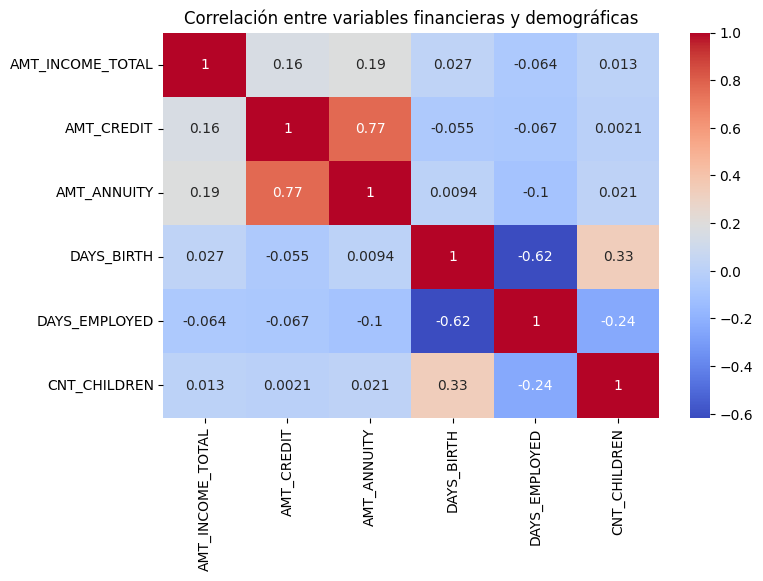

In [89]:
# Matriz de correlación
corr = app[vars_explorar].corr()

plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlación entre variables financieras y demográficas")
plt.show()

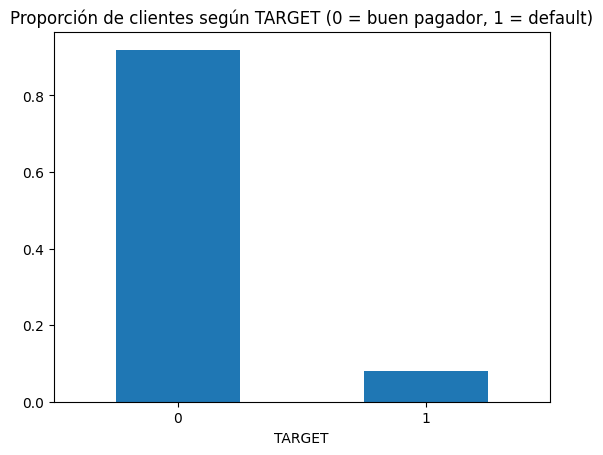

In [90]:
# Análisis de la variable TARGET
app["TARGET"].value_counts(normalize=True).plot(kind="bar")
plt.title("Proporción de clientes según TARGET (0 = buen pagador, 1 = default)")
plt.xticks(rotation=0)
plt.show()

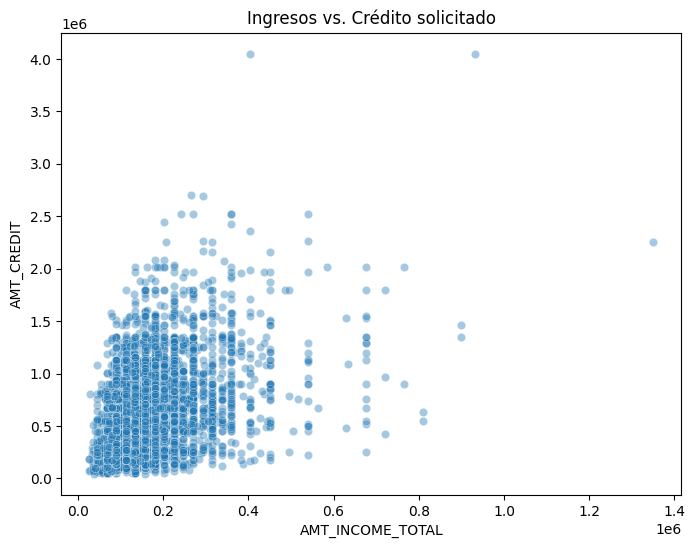

In [91]:
# Relación entre ingresos y monto de crédito solicitado
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=app.sample(5000), 
    x="AMT_INCOME_TOTAL", 
    y="AMT_CREDIT",
    alpha=0.4
)
plt.title("Ingresos vs. Crédito solicitado")
plt.show()

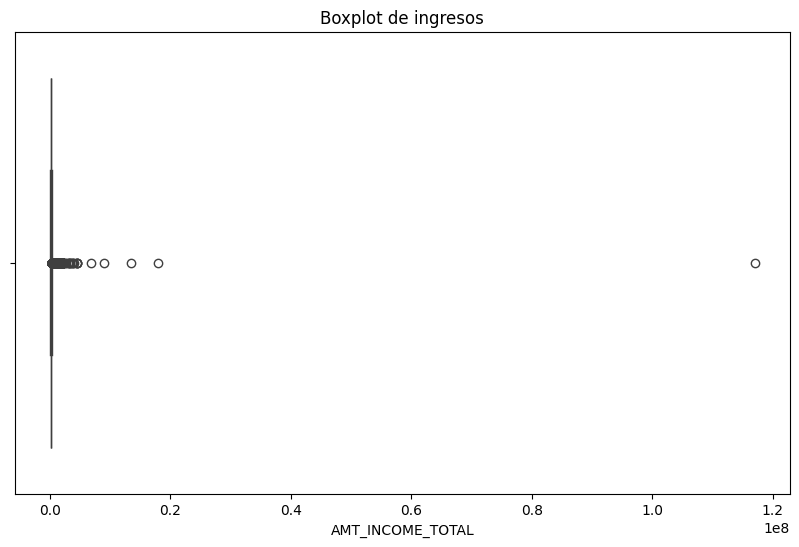

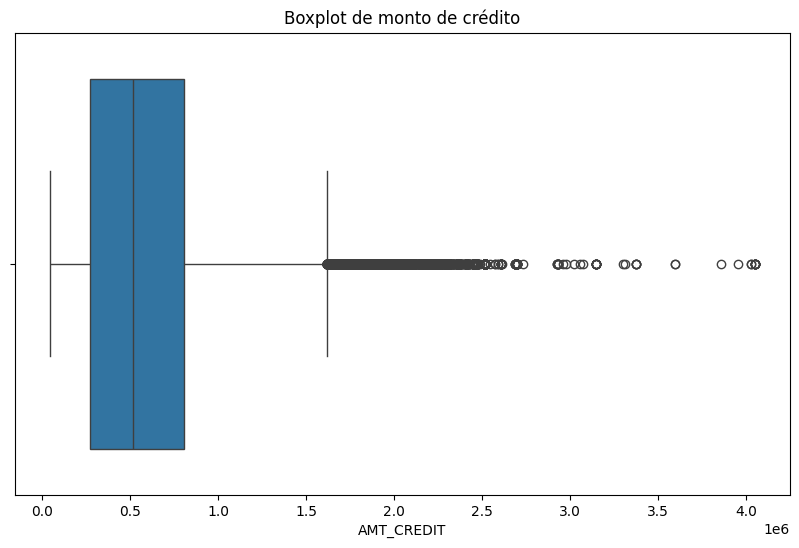

In [92]:
# Boxplots para detectar outlierss
plt.figure(figsize=(10,6))
sns.boxplot(x=app["AMT_INCOME_TOTAL"])
plt.title("Boxplot de ingresos")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x=app["AMT_CREDIT"])
plt.title("Boxplot de monto de crédito")
plt.show()

In [93]:
# Análisis de valores únicos en DAYS_EMPLOYED

# 365243 suele representar 'no trabaja'
print("Valores únicos más comunes en DAYS_EMPLOYED:")
print(app["DAYS_EMPLOYED"].value_counts().head())

Valores únicos más comunes en DAYS_EMPLOYED:
DAYS_EMPLOYED
 365243    55374
-200         156
-224         152
-230         151
-199         151
Name: count, dtype: int64


## Calidad de los datos

In [94]:
# Calidad de los datos
nulls = app.isnull().sum().sort_values(ascending=False)
percent_nulls = (app.isnull().mean() * 100).sort_values(ascending=False)

print("Columnas con más valores nulos:")
display(pd.DataFrame({
    "Nulos": nulls,
    "% Nulos": percent_nulls
}).head(20))

Columnas con más valores nulos:


,Nulos,% Nulos
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953


In [95]:
# Columnas con más del 40% de nulo
high_nulls = percent_nulls[percent_nulls > 40]
print("Columnas con más de 40% de valores nulos:")
display(high_nulls)

Columnas con más de 40% de valores nulos:


COMMONAREA_AVG                  69.872297
COMMONAREA_MODE                 69.872297
COMMONAREA_MEDI                 69.872297
NONLIVINGAPARTMENTS_MEDI        69.432963
NONLIVINGAPARTMENTS_MODE        69.432963
NONLIVINGAPARTMENTS_AVG         69.432963
FONDKAPREMONT_MODE              68.386172
LIVINGAPARTMENTS_AVG            68.354953
LIVINGAPARTMENTS_MEDI           68.354953
LIVINGAPARTMENTS_MODE           68.354953
FLOORSMIN_MODE                  67.848630
FLOORSMIN_AVG                   67.848630
FLOORSMIN_MEDI                  67.848630
YEARS_BUILD_AVG                 66.497784
YEARS_BUILD_MODE                66.497784
YEARS_BUILD_MEDI                66.497784
OWN_CAR_AGE                     65.990810
LANDAREA_MEDI                   59.376738
LANDAREA_AVG                    59.376738
LANDAREA_MODE                   59.376738
BASEMENTAREA_MODE               58.515956
BASEMENTAREA_MEDI               58.515956
BASEMENTAREA_AVG                58.515956
EXT_SOURCE_1                    56

In [96]:
# Valores especiales o fuera de rango

# Revisar frecuencia del valor anómalo en DAYS_EMPLOYED
print("Valores más frecuentes en DAYS_EMPLOYED:")
print(app["DAYS_EMPLOYED"].value_counts().head())

anomalia = (app["DAYS_EMPLOYED"] == 365243).sum()
print("\nCantidad de filas con valor 365243:", anomalia)

Valores más frecuentes en DAYS_EMPLOYED:
DAYS_EMPLOYED
 365243    55374
-200         156
-224         152
-230         151
-199         151
Name: count, dtype: int64

Cantidad de filas con valor 365243: 55374


In [97]:
# Filas duplicadas
duplicates = app.duplicated().sum()
print("Número de filas duplicadas:", duplicates)

Número de filas duplicadas: 0


In [98]:
# Resumen estadístico de variables clave
vars_rango = ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "CNT_CHILDREN"]

print(app[vars_rango].describe())

       AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY   CNT_CHILDREN
count      3.075110e+05  3.075110e+05  307499.000000  307511.000000
mean       1.687979e+05  5.990260e+05   27108.573909       0.417052
std        2.371231e+05  4.024908e+05   14493.737315       0.722121
min        2.565000e+04  4.500000e+04    1615.500000       0.000000
25%        1.125000e+05  2.700000e+05   16524.000000       0.000000
50%        1.471500e+05  5.135310e+05   24903.000000       0.000000
75%        2.025000e+05  8.086500e+05   34596.000000       1.000000
max        1.170000e+08  4.050000e+06  258025.500000      19.000000


In [99]:
# Valores imposibles o fuera de rango

# Edad en días -> Edad positiva en años
min_days = app["DAYS_BIRTH"].min()
max_days = app["DAYS_BIRTH"].max()

print("Rango de DAYS_BIRTH (en días):", min_days, "/", max_days)

# Convertir a años positivos
min_years = round(abs(min_days) / 365, 1)
max_years = round(abs(max_days) / 365, 1)

print("Rango de edad aproximado (en años):", min_years, "años /", max_years, "años")


Rango de DAYS_BIRTH (en días): -25229 / -7489
Rango de edad aproximado (en años): 69.1 años / 20.5 años


In [100]:
# Valores únicos en columnas categóricas
categoricas = app.select_dtypes(include=['object']).columns

for col in categoricas:
    print(f"\nColumna: {col}")
    print("Valores únicos:", app[col].unique())


Columna: NAME_CONTRACT_TYPE
Valores únicos: ['Cash loans' 'Revolving loans']

Columna: CODE_GENDER
Valores únicos: ['M' 'F' 'XNA']

Columna: FLAG_OWN_CAR
Valores únicos: ['N' 'Y']

Columna: FLAG_OWN_REALTY
Valores únicos: ['Y' 'N']

Columna: NAME_TYPE_SUITE
Valores únicos: ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' None
 'Other_B' 'Group of people']

Columna: NAME_INCOME_TYPE
Valores únicos: ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']

Columna: NAME_EDUCATION_TYPE
Valores únicos: ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

Columna: NAME_FAMILY_STATUS
Valores únicos: ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']

Columna: NAME_HOUSING_TYPE
Valores únicos: ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']

Columna: OCCUPATIO

In [101]:
# Columas con un solo valor
one_value_cols = [c for c in app.columns if app[c].nunique() <= 1]
print("Columnas con un solo valor:", one_value_cols)

Columnas con un solo valor: []


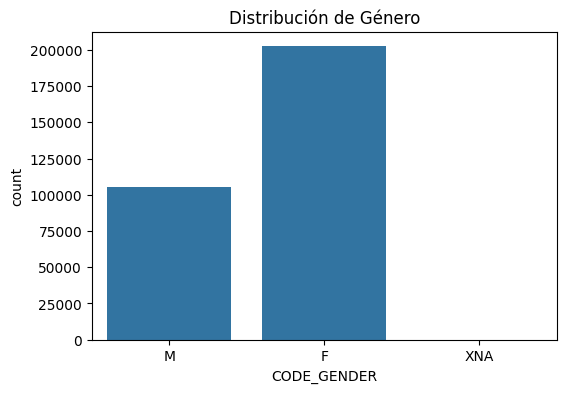


Distribución porcentual de CODE_GENDER:
CODE_GENDER
F      65.834393
M      34.164306
XNA     0.001301
Name: proportion, dtype: float64


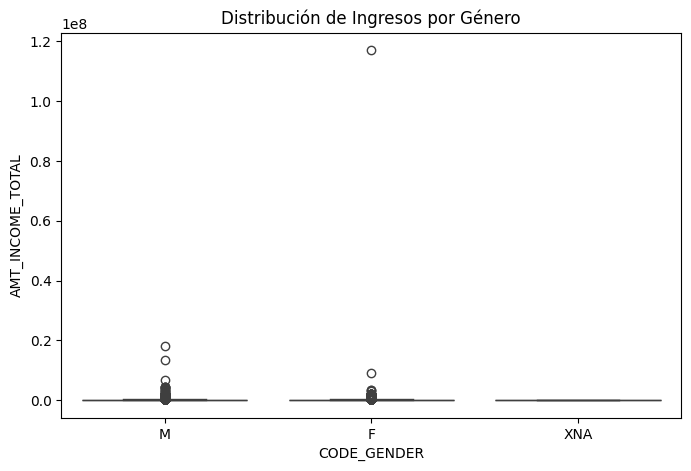


Tasa de default por género (%)
CODE_GENDER
F       6.999328
M      10.141920
XNA     0.000000
Name: TARGET, dtype: float64


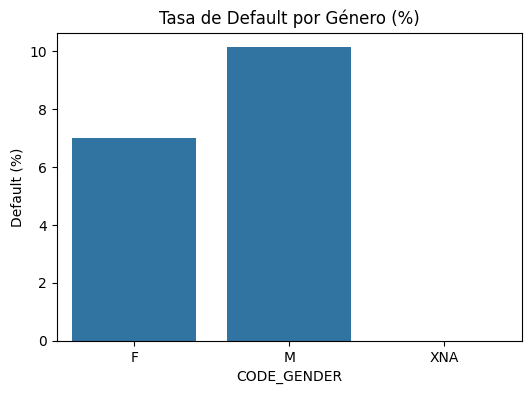

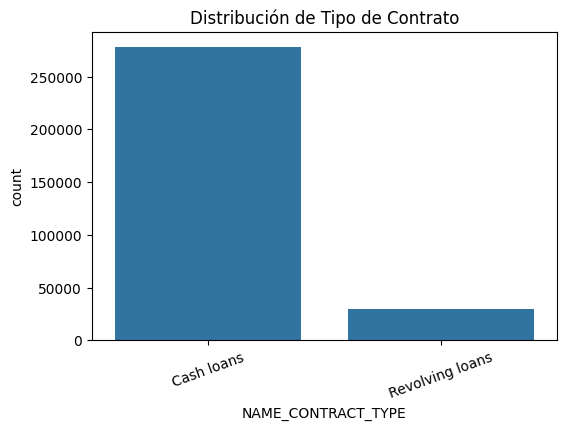


Distribución porcentual de NAME_CONTRACT_TYPE:
NAME_CONTRACT_TYPE
Cash loans         90.478715
Revolving loans     9.521285
Name: proportion, dtype: float64

Tasa de default por tipo de contrato (%)
NAME_CONTRACT_TYPE
Cash loans         8.345913
Revolving loans    5.478329
Name: TARGET, dtype: float64


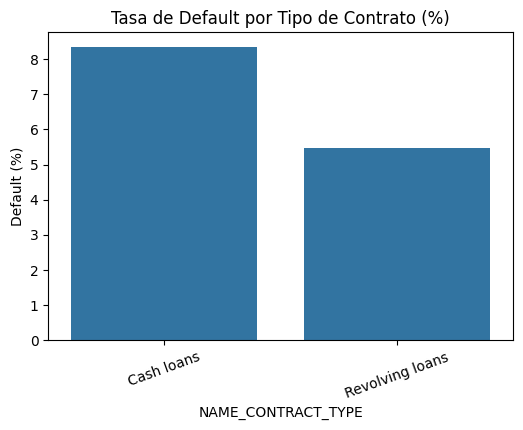

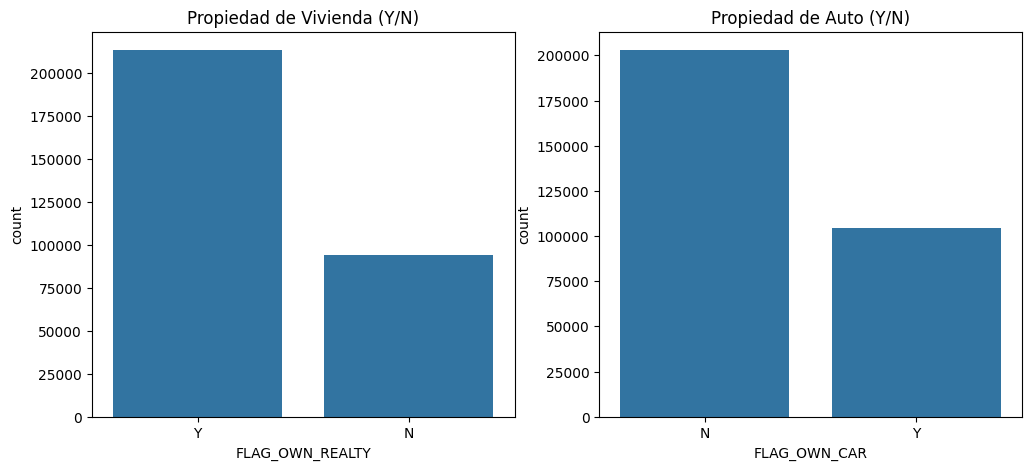


Default según propiedad de auto (%)
FLAG_OWN_CAR
N    8.500227
Y    7.243730
Name: TARGET, dtype: float64


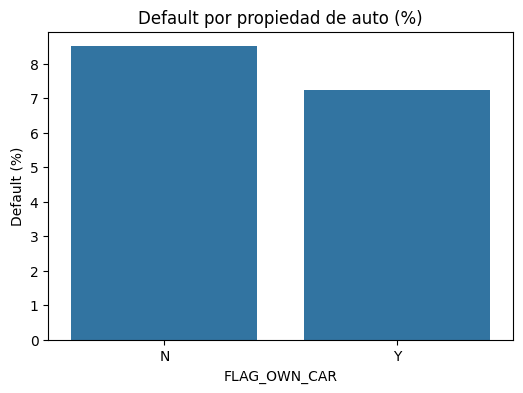


Default según propiedad de vivienda (%)
FLAG_OWN_REALTY
N    8.324929
Y    7.961577
Name: TARGET, dtype: float64


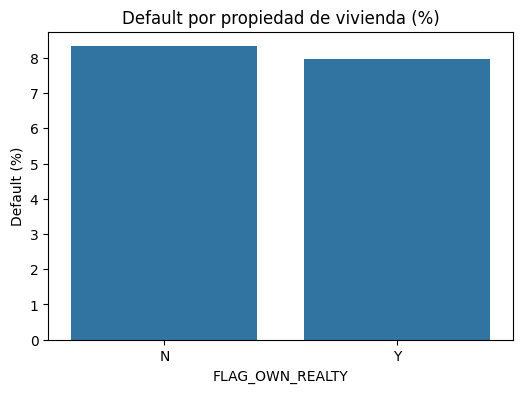

In [102]:
# Análisis de sesgos potenciales

# ---------------------------
# 1. SESGO EN GÉNERO
# ---------------------------
plt.figure(figsize=(6,4))
sns.countplot(data=app, x="CODE_GENDER")
plt.title("Distribución de Género")
plt.show()

print("\nDistribución porcentual de CODE_GENDER:")
print(app["CODE_GENDER"].value_counts(normalize=True) * 100)


# ---------------------------
# 2. INGRESOS POR GÉNERO
# ---------------------------
plt.figure(figsize=(8,5))
sns.boxplot(data=app, x="CODE_GENDER", y="AMT_INCOME_TOTAL")
plt.title("Distribución de Ingresos por Género")
plt.show()


# ---------------------------
# 3. DEFAULT SEGÚN GÉNERO
# ---------------------------
default_genero = app.groupby("CODE_GENDER")["TARGET"].mean() * 100
print("\nTasa de default por género (%)")
print(default_genero)

plt.figure(figsize=(6,4))
sns.barplot(x=default_genero.index, y=default_genero.values)
plt.title("Tasa de Default por Género (%)")
plt.ylabel("Default (%)")
plt.show()


# ---------------------------
# 4. SESGO EN TIPO DE CONTRATO
# ---------------------------
plt.figure(figsize=(6,4))
sns.countplot(data=app, x="NAME_CONTRACT_TYPE")
plt.title("Distribución de Tipo de Contrato")
plt.xticks(rotation=20)
plt.show()

print("\nDistribución porcentual de NAME_CONTRACT_TYPE:")
print(app["NAME_CONTRACT_TYPE"].value_counts(normalize=True) * 100)


# ---------------------------
# 5. DEFAULT SEGÚN TIPO DE CONTRATO
# ---------------------------
default_contrato = app.groupby("NAME_CONTRACT_TYPE")["TARGET"].mean() * 100
print("\nTasa de default por tipo de contrato (%)")
print(default_contrato)

plt.figure(figsize=(6,4))
sns.barplot(x=default_contrato.index, y=default_contrato.values)
plt.title("Tasa de Default por Tipo de Contrato (%)")
plt.ylabel("Default (%)")
plt.xticks(rotation=20)
plt.show()


# ---------------------------
# 6. PROPIEDAD DE VIVIENDA Y AUTO
# ---------------------------
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.countplot(data=app, x="FLAG_OWN_REALTY", ax=axes[0])
axes[0].set_title("Propiedad de Vivienda (Y/N)")

sns.countplot(data=app, x="FLAG_OWN_CAR", ax=axes[1])
axes[1].set_title("Propiedad de Auto (Y/N)")

plt.show()


# ---------------------------
# 7. DEFAULT SEGÚN PROPIEDAD DEL AUTO
# ---------------------------
default_auto = app.groupby("FLAG_OWN_CAR")["TARGET"].mean() * 100
print("\nDefault según propiedad de auto (%)")
print(default_auto)

plt.figure(figsize=(6,4))
sns.barplot(x=default_auto.index, y=default_auto.values)
plt.title("Default por propiedad de auto (%)")
plt.ylabel("Default (%)")
plt.show()


# ---------------------------
# 8. DEFAULT SEGÚN PROPIEDAD DE VIVIENDA
# ---------------------------
default_realty = app.groupby("FLAG_OWN_REALTY")["TARGET"].mean() * 100
print("\nDefault según propiedad de vivienda (%)")
print(default_realty)

plt.figure(figsize=(6,4))
sns.barplot(x=default_realty.index, y=default_realty.values)
plt.title("Default por propiedad de vivienda (%)")
plt.ylabel("Default (%)")
plt.show()


Rango de DAYS_BIRTH (en días): -25229 / -7489
Rango de edad aproximado (en años): 20.5 años / 69.1 años


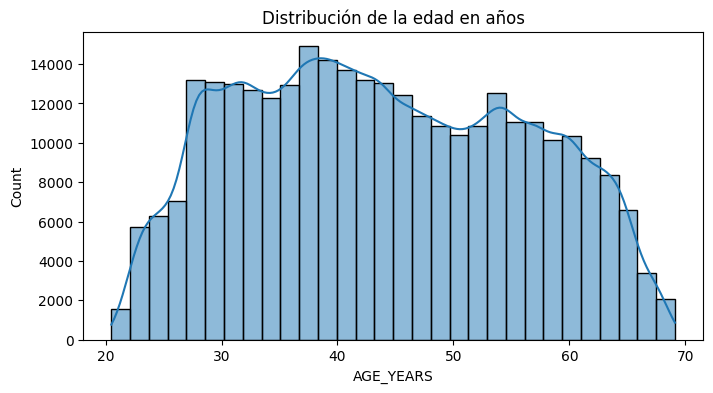


Registros con DAYS_EMPLOYED = 365243 (valor inválido): 55374


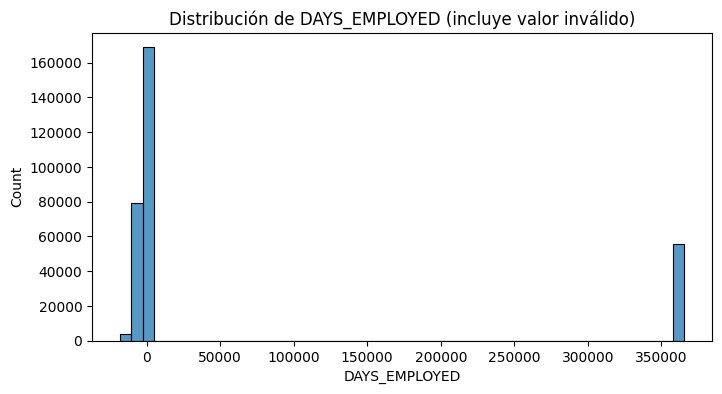


Registros donde los años trabajados superan la edad: 0

Rango DAYS_REGISTRATION: -24672.0 / 0.0


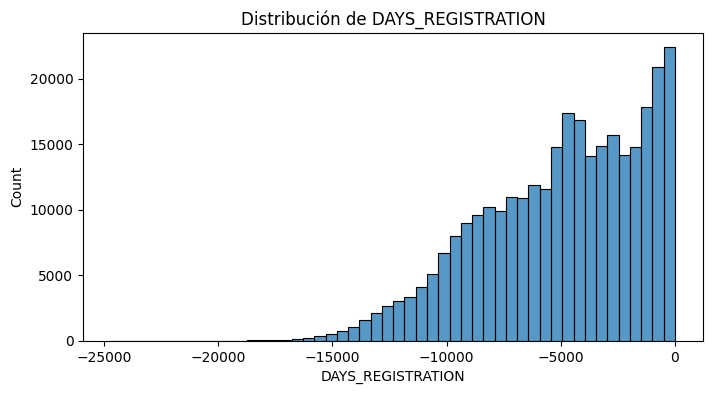


Rango DAYS_LAST_PHONE_CHANGE: -4292.0 / 0.0


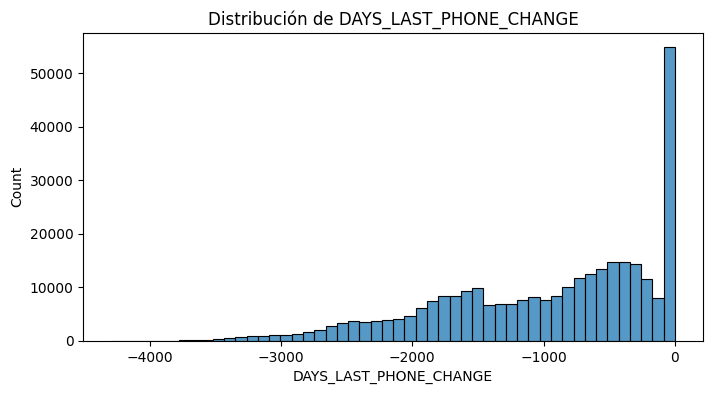

In [103]:
# Análisis de valores fuera de rango o inconsistentes

# ------------------------------------------------
# 1. EDAD (DAYS_BIRTH) -> convertir a años positivos
# ------------------------------------------------
app["AGE_YEARS"] = (-app["DAYS_BIRTH"] / 365).round(1)

print("Rango de DAYS_BIRTH (en días):",
      app["DAYS_BIRTH"].min(), "/", app["DAYS_BIRTH"].max())

print("Rango de edad aproximado (en años):",
      app["AGE_YEARS"].min(), "años /", app["AGE_YEARS"].max(), "años")

plt.figure(figsize=(8,4))
sns.histplot(app["AGE_YEARS"], bins=30, kde=True)
plt.title("Distribución de la edad en años")
plt.show()


# ------------------------------------------------
# 2. DÍAS DE EMPLEO (DAYS_EMPLOYED)
# ------------------------------------------------
anom_emp = (app["DAYS_EMPLOYED"] == 365243).sum()
print("\nRegistros con DAYS_EMPLOYED = 365243 (valor inválido):", anom_emp)

plt.figure(figsize=(8,4))
sns.histplot(app["DAYS_EMPLOYED"], bins=50)
plt.title("Distribución de DAYS_EMPLOYED (incluye valor inválido)")
plt.show()


# ------------------------------------------------
# 3. COMPARACIÓN: AÑOS DE EMPLEO > AÑOS DE EDAD
# ------------------------------------------------
app["EMPLOYED_YEARS"] = (-app["DAYS_EMPLOYED"] / 365)

# registros donde el empleo supera la edad (inconsistencia lógica)
inconsistentes = app[app["EMPLOYED_YEARS"] > app["AGE_YEARS"]]
print("\nRegistros donde los años trabajados superan la edad:", len(inconsistentes))


# ------------------------------------------------
# 4. FECHA DE REGISTRO (DAYS_REGISTRATION)
# ------------------------------------------------
print("\nRango DAYS_REGISTRATION:",
      app["DAYS_REGISTRATION"].min(),
      "/",
      app["DAYS_REGISTRATION"].max())

plt.figure(figsize=(8,4))
sns.histplot(app["DAYS_REGISTRATION"], bins=50)
plt.title("Distribución de DAYS_REGISTRATION")
plt.show()


# ------------------------------------------------
# 5. FECHA ÚLTIMO CAMBIO DE TELÉFONO
# ------------------------------------------------
print("\nRango DAYS_LAST_PHONE_CHANGE:",
      app["DAYS_LAST_PHONE_CHANGE"].min(),
      "/",
      app["DAYS_LAST_PHONE_CHANGE"].max())

plt.figure(figsize=(8,4))
sns.histplot(app["DAYS_LAST_PHONE_CHANGE"], bins=50)
plt.title("Distribución de DAYS_LAST_PHONE_CHANGE")
plt.show()

In [104]:
# Resumen de problemas detectados
print("\n=== Resumen de problemas detectados ===")
print("Columnas con altos nulos:", len(high_nulls))
print("Columnas con un solo valor:", len(one_value_cols))
print("Duplicados:", duplicates)
print("DAYS_EMPLOYED anomalías:", anomalia)



=== Resumen de problemas detectados ===
Columnas con altos nulos: 49
Columnas con un solo valor: 0
Duplicados: 0
DAYS_EMPLOYED anomalías: 55374


In [105]:
print("\nLista de columnas:")
for col in app.columns:
    print("-", col)


Lista de columnas:
- SK_ID_CURR
- TARGET
- NAME_CONTRACT_TYPE
- CODE_GENDER
- FLAG_OWN_CAR
- FLAG_OWN_REALTY
- CNT_CHILDREN
- AMT_INCOME_TOTAL
- AMT_CREDIT
- AMT_ANNUITY
- AMT_GOODS_PRICE
- NAME_TYPE_SUITE
- NAME_INCOME_TYPE
- NAME_EDUCATION_TYPE
- NAME_FAMILY_STATUS
- NAME_HOUSING_TYPE
- REGION_POPULATION_RELATIVE
- DAYS_BIRTH
- DAYS_EMPLOYED
- DAYS_REGISTRATION
- DAYS_ID_PUBLISH
- OWN_CAR_AGE
- FLAG_MOBIL
- FLAG_EMP_PHONE
- FLAG_WORK_PHONE
- FLAG_CONT_MOBILE
- FLAG_PHONE
- FLAG_EMAIL
- OCCUPATION_TYPE
- CNT_FAM_MEMBERS
- REGION_RATING_CLIENT
- REGION_RATING_CLIENT_W_CITY
- WEEKDAY_APPR_PROCESS_START
- HOUR_APPR_PROCESS_START
- REG_REGION_NOT_LIVE_REGION
- REG_REGION_NOT_WORK_REGION
- LIVE_REGION_NOT_WORK_REGION
- REG_CITY_NOT_LIVE_CITY
- REG_CITY_NOT_WORK_CITY
- LIVE_CITY_NOT_WORK_CITY
- ORGANIZATION_TYPE
- EXT_SOURCE_1
- EXT_SOURCE_2
- EXT_SOURCE_3
- APARTMENTS_AVG
- BASEMENTAREA_AVG
- YEARS_BEGINEXPLUATATION_AVG
- YEARS_BUILD_AVG
- COMMONAREA_AVG
- ELEVATORS_AVG
- ENTRANCES_AVG
- 

# 2. Preparación de los datos

In [ ]:
# Eliminación de columnas irrelevantes o ruidosas

# Indetificadores unicos y variable objetivo
cols_id_target = [
    "SK_ID_CURR",
    "TARGET"
]

# Flags de documentos (ruido, casi siempre 0)
cols_document_flags = [
    f"FLAG_DOCUMENT_{i}" for i in range(2, 22)
]

# Variables de proceso de solicitud
cols_process = [
    "WEEKDAY_APPR_PROCESS_START",
    "HOUR_APPR_PROCESS_START"
]

# Variables de mismatch entre región/ciudad (muy ruidosas)
cols_region_city_mismatch = [
    "REG_REGION_NOT_LIVE_REGION",
    "REG_REGION_NOT_WORK_REGION",
    "LIVE_REGION_NOT_WORK_REGION",
    "REG_CITY_NOT_LIVE_CITY",
    "REG_CITY_NOT_WORK_CITY",
    "LIVE_CITY_NOT_WORK_CITY"
]

# Variables sociales redundantes
cols_social = [
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE"
]

# Versiones AVG y MODE de variables (redundantes)
cols_avg_mode = [
    col for col in app.columns 
    if col.endswith("_AVG") or col.endswith("_MODE")
]

# Columnas redundantes del buró de crédito
cols_bureau_redundant = [
    "AMT_REQ_CREDIT_BUREAU_HOUR",
    "AMT_REQ_CREDIT_BUREAU_DAY",
    "AMT_REQ_CREDIT_BUREAU_WEEK",
    "AMT_REQ_CREDIT_BUREAU_MON",
    "AMT_REQ_CREDIT_BUREAU_QRT"
]

# Flags de teléfono (poco informativas)
cols_phone_flags = [
    "FLAG_MOBIL",
    "FLAG_CONT_MOBILE",
    "FLAG_PHONE"
]


# === Consolidar todas las columnas a eliminar ===
cols_to_drop = (
    cols_id_target +
    cols_document_flags +
    cols_process +
    cols_region_city_mismatch +
    cols_social +
    cols_avg_mode +
    cols_bureau_redundant +
    cols_phone_flags
)

print("Cantidad total de columnas a eliminar:", len(cols_to_drop))

# === Aplicar eliminación de columnas ===
app_clean = app.drop(columns=cols_to_drop, errors="ignore")

print("Dimensiones ANTES:", app.shape)
print("Dimensiones DESPUÉS:", app_clean.shape)

app = app_clean.copy()

# Vista previa de las columnas resultantes
print("\nColumnas restantes después del limpiado inicial:")
print(app_clean.columns.tolist())


Cantidad total de columnas a eliminar: 75
Dimensiones ANTES: (307511, 124)
Dimensiones DESPUÉS: (307511, 49)

Columnas restantes después del limpiado inicial:
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLI

In [107]:
# Eliminar columnas constantes
constant_cols = [col for col in app.columns if app[col].nunique() <= 1]

print("Columnas constantes eliminadas:")
print(constant_cols)

app = app.drop(columns=constant_cols)
print("Dimensiones después de eliminar constantes:", app.shape)


Columnas constantes eliminadas:
[]
Dimensiones después de eliminar constantes: (307511, 49)


In [ ]:
# Eliminar columnas de baja varianza

# Seleccionar solo columnas numéricas
numeric_cols = app.select_dtypes(include=['int64', 'float64']).columns

# Extraer subset numérico para medir varianza
numeric_data = app[numeric_cols]

# Threshold = 0 → elimina solo varianza EXACTAMENTE 0
# Subimos a 0.01 para eliminar columnas casi constantes
vt = VarianceThreshold(threshold=0.01)

vt.fit(numeric_data)

# Columnas que se mantienen
cols_kept = numeric_data.columns[vt.get_support()]
# Columnas eliminadas por baja varianza
cols_removed = list(set(numeric_data.columns) - set(cols_kept))

print("Columnas de baja varianza eliminadas:")
print(cols_removed)

# Actualizar el dataframe eliminando las columnas de baja varianza
app = app.drop(columns=cols_removed)
print("Dimensiones después de eliminar baja varianza:", app.shape)

Columnas de baja varianza eliminadas:
['NONLIVINGAPARTMENTS_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'REGION_POPULATION_RELATIVE', 'COMMONAREA_MEDI', 'LANDAREA_MEDI', 'NONLIVINGAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'BASEMENTAREA_MEDI']
Dimensiones después de eliminar baja varianza: (307511, 41)


In [109]:
numeric_cols = app.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = app.select_dtypes(include=['object']).columns.tolist()

print("Numéricas:", len(numeric_cols))
print("Categóricas:", len(categorical_cols))

Numéricas: 30
Categóricas: 11


In [110]:
# Asimetría de las variables numéricas
app[numeric_cols].skew().sort_values()

FLAG_EMP_PHONE                  -1.664886
EMPLOYED_YEARS                  -1.664346
YEARS_BUILD_MEDI                -0.962784
EXT_SOURCE_2                    -0.793576
DAYS_LAST_PHONE_CHANGE          -0.713606
DAYS_REGISTRATION               -0.590872
EXT_SOURCE_3                    -0.409390
DAYS_BIRTH                      -0.115673
EXT_SOURCE_1                    -0.068755
REGION_RATING_CLIENT_W_CITY      0.059730
REGION_RATING_CLIENT             0.087468
AGE_YEARS                        0.115651
DAYS_ID_PUBLISH                  0.349327
FLOORSMIN_MEDI                   0.960226
CNT_FAM_MEMBERS                  0.987543
AMT_CREDIT                       1.234778
FLOORSMAX_MEDI                   1.240185
AMT_REQ_CREDIT_BUREAU_YEAR       1.243590
AMT_GOODS_PRICE                  1.349000
FLAG_WORK_PHONE                  1.504950
AMT_ANNUITY                      1.579777
DAYS_EMPLOYED                    1.664346
CNT_CHILDREN                     1.974604
ENTRANCES_MEDI                   2

In [111]:
# Imputación de valores nulos en variables numéricas con la mediana
num_imputer = SimpleImputer(strategy='median')
app[numeric_cols] = num_imputer.fit_transform(app[numeric_cols])

# 2. Verificación: conteo de nulos restantes por columna numérica
nulls_after = app[numeric_cols].isna().sum()

print("Nulos restantes por columna numérica:")
print(nulls_after[nulls_after > 0])   # Solo imprime columnas con nulos

# 3. Verificación total de nulos después de la imputación
total_nulls = app[numeric_cols].isna().sum().sum()
print("\nTotal de valores nulos en variables numéricas después de imputación:", total_nulls)


Nulos restantes por columna numérica:
Series([], dtype: int64)

Total de valores nulos en variables numéricas después de imputación: 0


In [112]:
# Imputación de valores nulos en variables categóricas con la moda
categorical_cols = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 
                    'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 
                    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 
                    'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

# === Paso 1: Convertir None → np.nan (SimpleImputer NO reconoce None en objetos) ===
app[categorical_cols] = app[categorical_cols].replace({None: np.nan})

# === Paso 2: Verificar nulos antes de imputar ===
print("Nulos por columna categórica antes de imputación:")
print(app[categorical_cols].isna().sum())
print("\nTotal de nulos:", app[categorical_cols].isna().sum().sum())

# === Paso 3: Imputación con moda ===
cat_imputer = SimpleImputer(strategy='most_frequent')
app[categorical_cols] = cat_imputer.fit_transform(app[categorical_cols])

# === Paso 4: Verificar nulos después de imputación ===
print("\nNulos después de imputación:")
print(app[categorical_cols].isna().sum())
print("\nTotal de nulos después de imputación:", app[categorical_cols].isna().sum().sum())


Nulos por columna categórica antes de imputación:
NAME_CONTRACT_TYPE         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
NAME_TYPE_SUITE         1292
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
OCCUPATION_TYPE        96391
ORGANIZATION_TYPE          0
dtype: int64

Total de nulos: 97683

Nulos después de imputación:
NAME_CONTRACT_TYPE     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
NAME_TYPE_SUITE        0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
OCCUPATION_TYPE        0
ORGANIZATION_TYPE      0
dtype: int64

Total de nulos después de imputación: 0


In [113]:
# Columnas categóricas que necesitan OneHotEncoding

# Categóricas reales (object)
categorical_detected = app.select_dtypes(include=['object']).columns.tolist()

print("Categóricas detectadas:", categorical_detected)

# Remover la columna ordinal (que será convertida y eliminada)
ordinal_col = 'NAME_EDUCATION_TYPE'

cols_to_encode = [col for col in categorical_detected if col != ordinal_col]

print("\nColumnas que necesitan OneHotEncoding:")
for col in cols_to_encode:
    print(" -", col)

print("\nTotal:", len(cols_to_encode))


Categóricas detectadas: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE']

Columnas que necesitan OneHotEncoding:
 - NAME_CONTRACT_TYPE
 - CODE_GENDER
 - FLAG_OWN_CAR
 - FLAG_OWN_REALTY
 - NAME_TYPE_SUITE
 - NAME_INCOME_TYPE
 - NAME_FAMILY_STATUS
 - NAME_HOUSING_TYPE
 - OCCUPATION_TYPE
 - ORGANIZATION_TYPE

Total: 10


In [114]:
# Encoding de la variable ordinal 'NAME_EDUCATION_TYPE'

education_map = {
    'Lower secondary': 0,
    'Secondary / secondary special': 1,
    'Incomplete higher': 2,
    'Higher education': 3,
    'Academic degree': 4
}

# Crear variable ordinal
app['EDU_LEVEL'] = app['NAME_EDUCATION_TYPE'].map(education_map)

# Validar que no haya nulos generados
print("Nulos generados por el mapeo ordinal:", app['EDU_LEVEL'].isna().sum())

# Eliminar columna original
app.drop(columns=['NAME_EDUCATION_TYPE'], inplace=True)


# Encoding One-Hot para las demás variables categóricas

cols_to_encode = [
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE'
]

encoder = OneHotEncoder(drop='first', sparse_output=False)

encoded = encoder.fit_transform(app[cols_to_encode])

encoded_df = pd.DataFrame(
    encoded,
    columns=encoder.get_feature_names_out(cols_to_encode),
    index=app.index
)


# Remover columnas originales y agregar las nuevas

# Eliminamos directamente las columnas categóricas originales de app
app.drop(columns=cols_to_encode, inplace=True)

# Agregamos las columnas one-hot
app = pd.concat([app, encoded_df], axis=1)

# =============================================================
# === 4. REVISIÓN FINAL =======================================
# =============================================================

print("Encoding completado correctamente.")
print("Nuevas dimensiones del dataset:", app.shape)
app.head()

Nulos generados por el mapeo ordinal: 0
Encoding completado correctamente.
Nuevas dimensiones del dataset: (307511, 133)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,0.0,202500.0,406597.5,24700.5,351000.0,-9461.0,-637.0,-3648.0,-2120.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,270000.0,1293502.5,35698.5,1129500.0,-16765.0,-1188.0,-1186.0,-291.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,67500.0,135000.0,6750.0,135000.0,-19046.0,-225.0,-4260.0,-2531.0,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,135000.0,312682.5,29686.5,297000.0,-19005.0,-3039.0,-9833.0,-2437.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,121500.0,513000.0,21865.5,513000.0,-19932.0,-3038.0,-4311.0,-3458.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
# Convertir columnas temporales a años
app['YEARS_BIRTH'] = (app['DAYS_BIRTH'] / 365).abs()
app['YEARS_EMPLOYED'] = (app['DAYS_EMPLOYED'] / 365).abs()
app['YEARS_REGISTRATION'] = (app['DAYS_REGISTRATION'] / 365).abs()
app['YEARS_ID_PUBLISH'] = (app['DAYS_ID_PUBLISH'] / 365).abs()

# Luego podemos eliminar las columnas en días si quieres
app.drop(columns=[
    'DAYS_BIRTH', 'DAYS_EMPLOYED',
    'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH'
], inplace=True)


In [116]:
app.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,...,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,YEARS_BIRTH,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH
0,0.0,202500.0,406597.5,24700.5,351000.0,9.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,25.920548,1.745205,9.994521,5.808219
1,0.0,270000.0,1293502.5,35698.5,1129500.0,9.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,45.931507,3.254795,3.249315,0.797260
2,0.0,67500.0,135000.0,6750.0,135000.0,26.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,52.180822,0.616438,11.671233,6.934247
3,0.0,135000.0,312682.5,29686.5,297000.0,9.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,52.068493,8.326027,26.939726,6.676712
4,0.0,121500.0,513000.0,21865.5,513000.0,9.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,54.608219,8.323288,11.810959,9.473973



=== StandardScaler Stats ===
                               mean       std       min         max
CNT_CHILDREN          -4.815343e-17  1.000002 -0.577538   25.733871
AMT_INCOME_TOTAL      -1.229253e-17  1.000002 -0.603687  492.703449
AMT_CREDIT            -4.545000e-17  1.000002 -1.376496    8.574059
AMT_ANNUITY           -1.793045e-17  1.000002 -1.758933   15.932522
AMT_GOODS_PRICE       -9.150077e-18  1.000002 -1.348042    9.509326
...                             ...       ...       ...         ...
ORGANIZATION_TYPE_XNA -1.663650e-18  1.000002 -0.468635    2.133857
YEARS_BIRTH           -1.061039e-16  1.000002 -1.958761    2.106335
YEARS_EMPLOYED        -2.772751e-17  1.000002 -0.485679    2.133611
YEARS_REGISTRATION     1.715408e-16  1.000002 -1.415353    5.588007
YEARS_ID_PUBLISH      -2.425232e-16  1.000002 -1.983641    2.784328

[133 rows x 4 columns]

=== MinMaxScaler Stats ===
                       min  max
CNT_CHILDREN           0.0  1.0
AMT_INCOME_TOTAL       0.0  1.0
AMT_CR

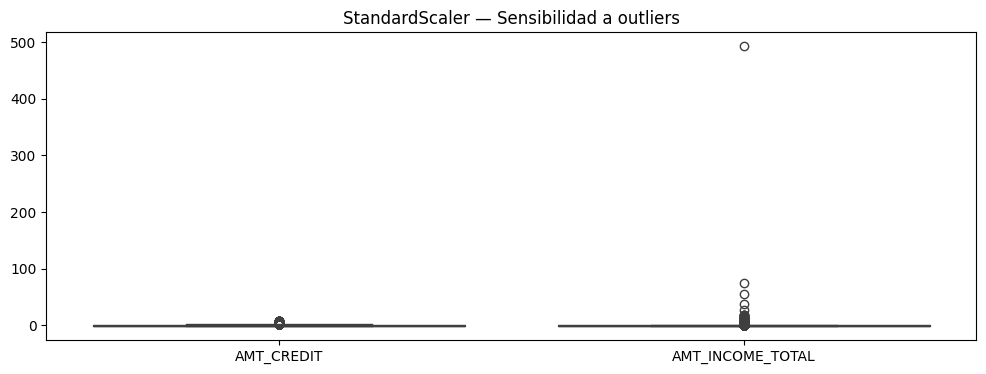

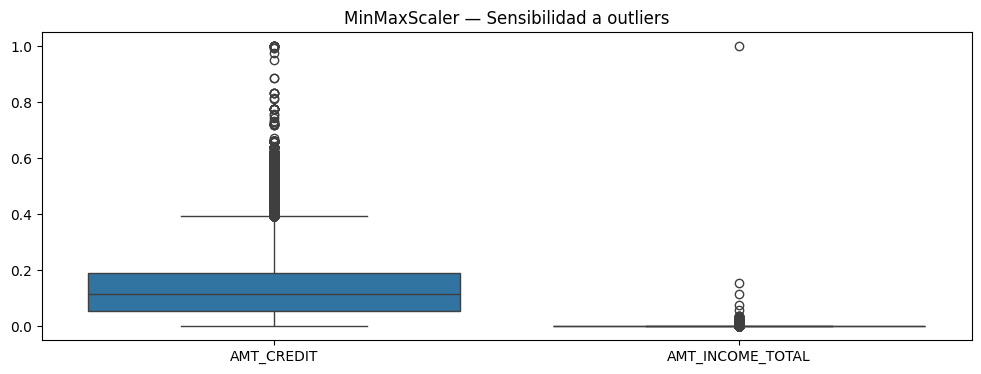


Inercia (KMeans) con StandardScaler: [40484959.36498911, 38370441.63764477, 37647560.72910242, 37164762.02523846]
Inercia (KMeans) con MinMaxScaler: [1304062.078291648, 1230023.683365949, 1179707.355795591, 1158245.5104588217]


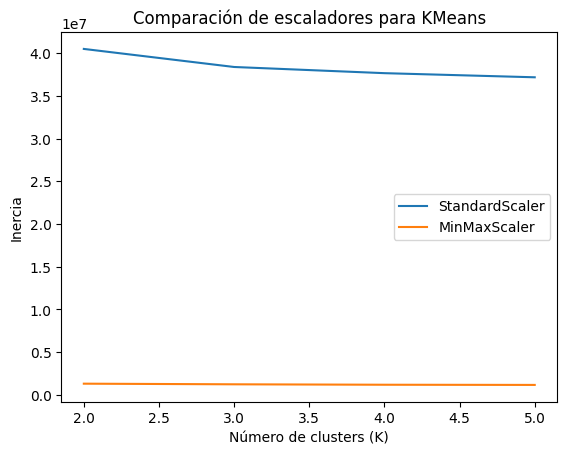

In [117]:
# Comparación entre StandardScaler y MinMaxScaler

# Dataset a comparar
X = app.copy()

# Aplicar ambos escaladores

std_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

X_std = pd.DataFrame(std_scaler.fit_transform(X), columns=X.columns)
X_minmax = pd.DataFrame(minmax_scaler.fit_transform(X), columns=X.columns)

# Comparación de estadísticas descriptivas

print("\n=== StandardScaler Stats ===")
print(X_std.describe().T[['mean','std','min','max']])

print("\n=== MinMaxScaler Stats ===")
print(X_minmax.describe().T[['min','max']])

# Sensibilidad a outliers

plt.figure(figsize=(12,4))
sns.boxplot(data=X_std[['AMT_CREDIT','AMT_INCOME_TOTAL']])
plt.title("StandardScaler — Sensibilidad a outliers")
plt.show()

plt.figure(figsize=(12,4))
sns.boxplot(data=X_minmax[['AMT_CREDIT','AMT_INCOME_TOTAL']])
plt.title("MinMaxScaler — Sensibilidad a outliers")
plt.show()

# Comparación de inercia en KMeans

def inertia_for(X_scaled):
    inertias = []
    for k in range(2, 6):
        km = KMeans(n_clusters=k, random_state=42)
        km.fit(X_scaled)
        inertias.append(km.inertia_)
    return inertias

inertia_std = inertia_for(X_std)
inertia_minmax = inertia_for(X_minmax)

print("\nInercia (KMeans) con StandardScaler:", inertia_std)
print("Inercia (KMeans) con MinMaxScaler:", inertia_minmax)

plt.plot(range(2,6), inertia_std, label="StandardScaler")
plt.plot(range(2,6), inertia_minmax, label="MinMaxScaler")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia")
plt.title("Comparación de escaladores para KMeans")
plt.legend()
plt.show()


In [118]:
# Escalado final del dataset con MinMaxScaler

# Todas las variables actuales ya son numéricas
features = app.columns.tolist()

scaler = MinMaxScaler()

# Escalado
app_scaled = scaler.fit_transform(app)

# Crear DataFrame final
app_tratado = pd.DataFrame(app_scaled, columns=features, index=app.index)

print("\n=== Dataset escalado con MinMaxScaler ===")
print(app_tratado.head())

print("\nRango general tras MinMaxScaler (debería ser 0–1):")
print(app_tratado.describe().loc[['min','max']])


=== Dataset escalado con MinMaxScaler ===
   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0           0.0          0.001512    0.090287     0.090032         0.077441   
1           0.0          0.002089    0.311736     0.132924         0.271605   
2           0.0          0.000358    0.022472     0.020025         0.023569   
3           0.0          0.000935    0.066837     0.109477         0.063973   
4           0.0          0.000819    0.116854     0.078975         0.117845   

   OWN_CAR_AGE  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0     0.098901             1.0              0.0         0.0         0.000000   
1     0.098901             1.0              0.0         0.0         0.052632   
2     0.285714             1.0              1.0         0.0         0.000000   
3     0.098901             1.0              0.0         0.0         0.052632   
4     0.098901             1.0              0.0         0.0         0.000000   

 

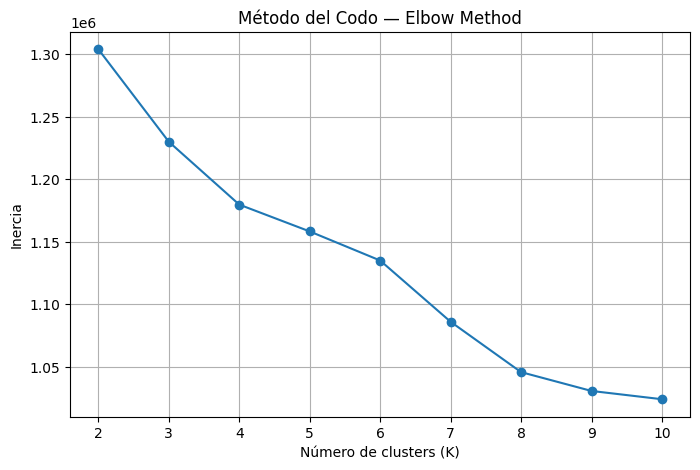

Inercias: [1304062.078291648, 1230023.683365949, 1179707.355795591, 1158245.5104588217, 1134964.8386199484, 1085944.941574001, 1045634.9170293735, 1030561.4575264137, 1023950.7488765427]


In [126]:
# Metodo del codo para determinar K óptimo

inertias = []

K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(app_tratado)
    inertias.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertias, marker='o')
plt.title("Método del Codo — Elbow Method")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()

print("Inercias:", inertias)



Silhouette Score por K:
K=2: 0.2118
K=3: 0.1604
K=4: 0.1444
K=5: 0.1250
K=6: 0.1233
K=7: 0.1210
K=8: 0.1249
K=9: 0.0824
K=10: 0.0805


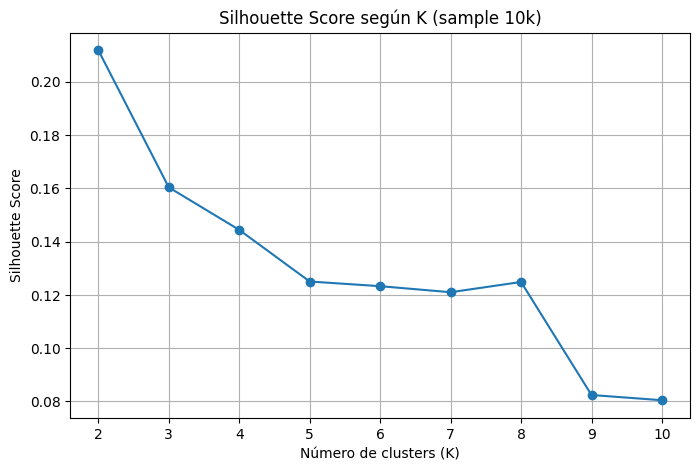

In [135]:
# Cálculo del Silhouette Score para diferentes valores de K

sample_size = 10000
app_sample = shuffle(app_tratado, random_state=42).iloc[:sample_size]

# Cálculo del Silhouette Score para K=2 a K=10
sil_scores = {}

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(app_sample)
    sil = silhouette_score(app_sample, labels)
    sil_scores[k] = sil

print("\nSilhouette Score por K:")
for k, v in sil_scores.items():
    print(f"K={k}: {v:.4f}")

plt.figure(figsize=(8,5))
plt.plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o')
plt.title("Silhouette Score según K (sample 10k)")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [136]:
# Entrenamiento final de KMeans con K=4

K = 4
kmeans_final = KMeans(n_clusters=K, random_state=42, n_init='auto')

# Entrenar usando el dataset escalado
clusters = kmeans_final.fit_predict(app_tratado)

# Agregar la columna de clusters al dataset
app_con_clusters = app_tratado.copy()
app_con_clusters["CLUSTER"] = clusters

# Verificar distribución
print(app_con_clusters["CLUSTER"].value_counts())

CLUSTER
1    97831
0    82278
3    72028
2    55374
Name: count, dtype: int64


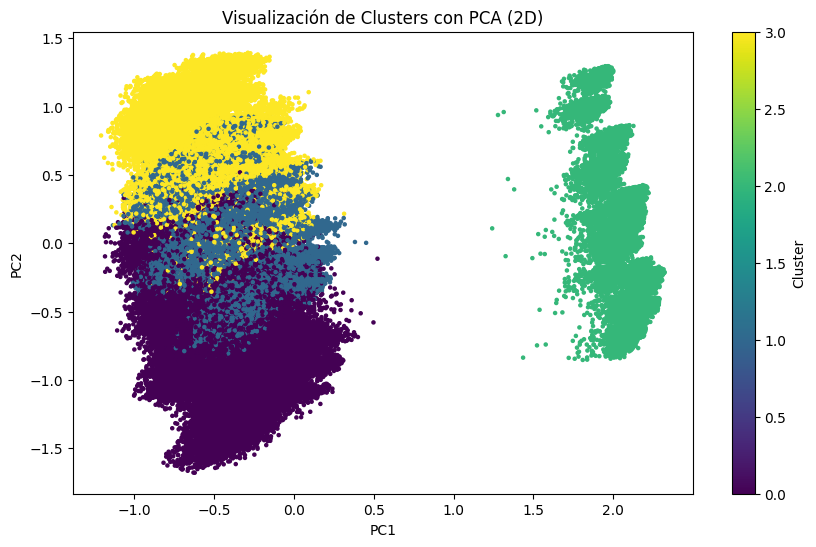

In [139]:
# Visualización de clusters con PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(app_tratado)

# Crear DataFrame para plot
pca_df = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'Cluster': clusters
})

plt.figure(figsize=(10,6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis', s=5)
plt.title("Visualización de Clusters con PCA (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

In [140]:
centroides = pd.DataFrame(kmeans_final.cluster_centers_, columns=app_tratado.columns)
centroides


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,...,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,YEARS_BIRTH,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH
0,0.015813,0.001239,0.121501,0.091434,0.108066,0.109453,9.999878e-01,0.230682,0.065385,0.029937,...,8.871928e-04,7.206923e-03,3.536618e-03,1.928733e-02,5.468997e-03,1.043610e-14,0.389523,0.005951,0.197880,0.380508
1,0.030774,0.001147,0.150649,0.104768,0.135553,0.107047,9.999591e-01,0.254664,0.062240,0.083405,...,6.848545e-04,6.654332e-03,1.349266e-03,1.149942e-02,6.296573e-03,3.894107e-14,0.419254,0.007256,0.186134,0.373639
2,0.002428,0.000947,0.124267,0.086926,0.111680,0.107156,9.237056e-14,0.000018,0.025842,0.036736,...,2.233456e-17,-5.663872e-16,5.603157e-16,-3.295975e-16,6.192963e-16,1.000000e+00,0.807272,1.000000,0.266818,0.538497
3,0.031985,0.001524,0.151650,0.110896,0.136662,0.118279,9.999028e-01,0.241753,0.063062,0.083284,...,8.469399e-04,1.332889e-02,1.060758e-02,3.729312e-02,3.623792e-03,-1.501577e-14,0.422152,0.006197,0.178835,0.420057


In [119]:
app_tratado.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,OWN_CAR_AGE,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,...,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA,YEARS_BIRTH,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH
0,0.0,0.001512,0.090287,0.090032,0.077441,0.098901,1.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.111161,0.001744,0.147860,0.294567
1,0.0,0.002089,0.311736,0.132924,0.271605,0.098901,1.0,0.0,0.0,0.052632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.522886,0.003253,0.048071,0.040434
2,0.0,0.000358,0.022472,0.020025,0.023569,0.285714,1.0,1.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.651466,0.000616,0.172665,0.351674
3,0.0,0.000935,0.066837,0.109477,0.063973,0.098901,1.0,0.0,0.0,0.052632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.649154,0.008320,0.398549,0.338613
4,0.0,0.000819,0.116854,0.078975,0.117845,0.098901,1.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.701409,0.008318,0.174732,0.480478


In [120]:
print("\nLista de columnas:")
for col in app_tratado.columns:
    print("-", col)


Lista de columnas:
- CNT_CHILDREN
- AMT_INCOME_TOTAL
- AMT_CREDIT
- AMT_ANNUITY
- AMT_GOODS_PRICE
- OWN_CAR_AGE
- FLAG_EMP_PHONE
- FLAG_WORK_PHONE
- FLAG_EMAIL
- CNT_FAM_MEMBERS
- REGION_RATING_CLIENT
- REGION_RATING_CLIENT_W_CITY
- EXT_SOURCE_1
- EXT_SOURCE_2
- EXT_SOURCE_3
- APARTMENTS_MEDI
- YEARS_BUILD_MEDI
- ELEVATORS_MEDI
- ENTRANCES_MEDI
- FLOORSMAX_MEDI
- FLOORSMIN_MEDI
- LIVINGAREA_MEDI
- DAYS_LAST_PHONE_CHANGE
- AMT_REQ_CREDIT_BUREAU_YEAR
- AGE_YEARS
- EMPLOYED_YEARS
- EDU_LEVEL
- NAME_CONTRACT_TYPE_Revolving loans
- CODE_GENDER_M
- CODE_GENDER_XNA
- FLAG_OWN_CAR_Y
- FLAG_OWN_REALTY_Y
- NAME_TYPE_SUITE_Family
- NAME_TYPE_SUITE_Group of people
- NAME_TYPE_SUITE_Other_A
- NAME_TYPE_SUITE_Other_B
- NAME_TYPE_SUITE_Spouse, partner
- NAME_TYPE_SUITE_Unaccompanied
- NAME_INCOME_TYPE_Commercial associate
- NAME_INCOME_TYPE_Maternity leave
- NAME_INCOME_TYPE_Pensioner
- NAME_INCOME_TYPE_State servant
- NAME_INCOME_TYPE_Student
- NAME_INCOME_TYPE_Unemployed
- NAME_INCOME_TYPE_Working